In [1]:
import requests
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import os 

from dotenv import load_dotenv

In [2]:
load_dotenv()

True

### Alpha Vantage Time Series

In [3]:
AV_API_KEY = os.getenv('AV_API_KEY')
BASE_URL = 'https://www.alphavantage.co/query?'
TICKER = 'SPY'

In [4]:
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": TICKER,
    "outputsize":"compact",
    "apikey": AV_API_KEY
}

resp = requests.get(BASE_URL,params=params)

In [5]:
ts = resp.json()['Time Series (Daily)']

In [6]:
close_ts = {datetime.strptime(tick, '%Y-%m-%d'):float(ts[tick]['5. adjusted close']) for tick in ts}

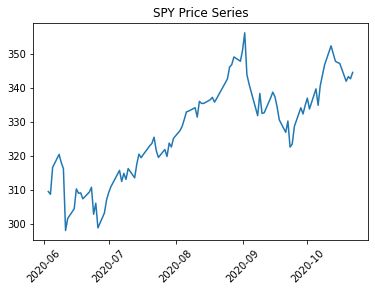

In [7]:
fig = sns.lineplot(x = close_ts.keys(),y = close_ts.values())
fig.set_title(f"{TICKER} Price Series")
plt.xticks(rotation=45)
plt.show()

### FRED Gross Domestic Income Share 

In [53]:
FRED_API_KEY = os.getenv('FRED_API_KEY')
FRED_BASE_URL = 'https://api.stlouisfed.org/fred/'
endpoint = 'series/observations'

In [54]:
profit_params = {
    "series_id":"W271RE1A156NBEA",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "realtime_start": "1900-01-01",
    "realtime_end": "2020-10-23"
}

resp = requests.get(FRED_BASE_URL + endpoint,params = profit_params)
profit_share = resp.json()['observations']
net_profits = {datetime.strptime(p['date'], '%Y-%m-%d'):float(p['value']) for p in profit_share}

In [55]:
labor_params = {
    "series_id":"W270RE1A156NBEA",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "realtime_start": "1900-01-01",
    "realtime_end": "2020-10-23"
}

resp = requests.get(FRED_BASE_URL + endpoint,params = labor_params)
labor_share = resp.json()['observations']
labor = {datetime.strptime(p['date'], '%Y-%m-%d'):float(p['value']) for p in labor_share}

In [56]:
labor_benefits_params = {
    "series_id":"A4002E1A156NBEA",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "realtime_start": "1900-01-01",
    "realtime_end": "2020-10-23"
}

resp = requests.get(FRED_BASE_URL + endpoint,params = labor_benefits_params)
labor_benefits_share = resp.json()['observations']
labor_benefits = {datetime.strptime(p['date'], '%Y-%m-%d'):float(p['value']) for p in labor_benefits_share}

In [57]:
depreciation_params = {
    "series_id":"A262RE1A156NBEA",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "realtime_start": "1900-01-01",
    "realtime_end": "2020-10-23"
}

resp = requests.get(FRED_BASE_URL + endpoint,params = depreciation_params)
depreciation_share = resp.json()['observations']
depreciation = {datetime.strptime(p['date'], '%Y-%m-%d'):float(p['value']) for p in depreciation_share}

In [58]:
taxes_params = {
    "series_id":"W056RE1A156NBEA",
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "realtime_start": "1900-01-01",
    "realtime_end": "2020-10-23"
}

resp = requests.get(FRED_BASE_URL + endpoint,params = taxes_params)
taxes_share = resp.json()['observations']
taxes = {datetime.strptime(p['date'], '%Y-%m-%d'):float(p['value']) for p in taxes_share}

In [59]:
net_profits = pd.DataFrame.from_dict(net_profits,orient='index')
net_profits.columns = ['net_profits']

taxes = pd.DataFrame.from_dict(taxes,orient='index')
taxes.columns = ['taxes']

depreciation = pd.DataFrame.from_dict(depreciation,orient='index')
depreciation.columns = ['depreciation']

labor_benefits = pd.DataFrame.from_dict(labor_benefits,orient='index')
labor_benefits.columns = ['labor_benefits']

labor = pd.DataFrame.from_dict(labor,orient='index')
labor.columns = ['labor']

In [93]:
gdi = net_profits.merge(taxes,how='inner',left_index=True,right_index=True)
gdi = gdi.merge(labor_benefits,how='inner',left_index=True,right_index=True)
gdi = gdi.merge(labor,how='inner',left_index=True,right_index=True)
gdi = gdi.merge(depreciation,how='inner',left_index=True,right_index=True)

In [94]:
gdi.head()

,net_profits,taxes,labor_benefits,labor,depreciation
1959-01-01,25.0,7.9,54.8,49.8,12.6
1960-01-01,24.1,8.2,55.4,50.2,12.5
1961-01-01,24.3,8.3,55.2,49.8,12.5
1962-01-01,24.7,8.3,55.0,49.5,12.3
1963-01-01,24.9,8.4,54.9,49.3,12.2


In [95]:
gdi.corr()

,net_profits,taxes,labor_benefits,labor,depreciation
net_profits,1.000000,-0.059199,-0.818807,-0.329762,-0.184184
taxes,-0.059199,1.000000,0.432519,0.816780,-0.842862
labor_benefits,-0.818807,0.432519,1.000000,0.758813,-0.382151
labor,-0.329762,0.816780,0.758813,1.000000,-0.834597
depreciation,-0.184184,-0.842862,-0.382151,-0.834597,1.000000


Text(0.5, 1.0, 'Gross Domestic Income Components')

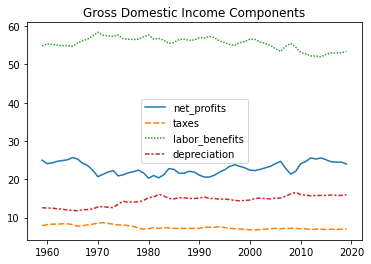

In [97]:
components = ['net_profits','taxes','labor_benefits','depreciation']
fig = sns.lineplot(data=gdi[components])
fig.set_title('Gross Domestic Income Components')

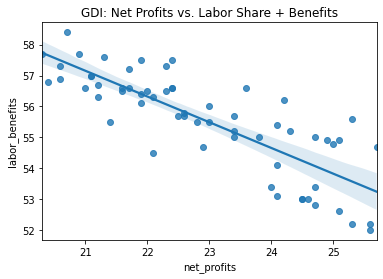

In [100]:
fig = sns.regplot(x=gdi['net_profits'],y=gdi['labor_benefits'])
fig.set_title('GDI: Net Profit Share vs. Labor Share + Benefits Share')
plt.show()

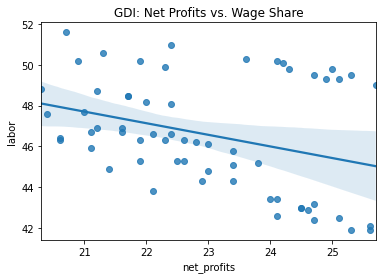

In [103]:
fig = sns.regplot(x=gdi['net_profits'],y=gdi['labor'])
fig.set_title('GDI: Net Profits vs. Wage Share')
plt.show()

Labor share of income most negatively correlated with net profits and fixed capital consumption (depreciation), which makes sense - rising capital-intensity of labor is accompanied by increased depreciation and reduced labor input/income